<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D0%BF%D1%80%D0%B8_%D0%BF%D0%BE%D0%B3%D0%BB%D0%BE%D1%89%D0%B5%D0%BD%D0%B8%D0%B8_OB_%D0%BF%D1%80%D0%BE%D1%82%D0%B8%D0%B2_%D0%B3%D0%B0%D0%BB%D0%B0%D0%BA%D1%82%D0%B8%D0%BA_%D0%B8_%D0%BA%D0%B2%D0%B0%D0%B7%D0%B0%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Подгружаем необходимые библиотеки 

In [175]:
import numpy as np
import pandas as pd

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [177]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

Подгружаем данные из SDSS обзора, которые были получены: http://skyserver.sdss.org/CasJobs/mydbcontent.aspx?ObjName=SpecPhotoAll&ObjType=TABLE&context=DR16&type=normal 

Здесь уже выполнены следующие преобразования:

1) Удалены строчки с разряженными данными (где отсутствуют интересующие нас фотометрические признаки), выбросы, удалены не интересующие нас признаки

2) Удалены дубрирующиеся данные

3) Объединены основные спектральные классы звезд 

In [178]:
df = pd.read_csv('/content/drive/MyDrive/Научная работа /Nauch/Результат/data/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [179]:
df.shape

(4614588, 17)

In [180]:
df.describe()

,objID,ra,dec,z,zErr,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
count,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06
mean,1.237665e+18,1.728012e+02,2.406577e+01,5.773699e-01,5.854844e-02,2.240051e+01,2.122111e+01,2.029666e+01,1.974275e+01,1.938488e+01,2.136179e+01,2.051423e+01,1.961589e+01,1.905677e+01,1.868825e+01
std,8.417649e+12,9.444408e+01,1.910161e+01,7.297733e-01,1.930832e+01,1.954846e+00,1.940199e+00,1.713228e+00,1.552831e+00,1.512268e+00,2.117606e+00,1.993697e+00,1.852755e+00,1.742048e+00,1.677772e+00
min,1.237646e+18,9.090791e-05,-1.970271e+01,-1.144691e-02,-6.000000e+00,6.752299e+00,7.464891e+00,8.449972e+00,7.611034e+00,6.444011e+00,1.020505e+01,1.043573e+01,1.033073e+01,1.027642e+01,8.829096e+00
25%,1.237659e+18,1.271012e+02,6.893257e+00,6.228666e-02,2.494150e-05,2.105644e+01,1.980771e+01,1.908989e+01,1.871800e+01,1.840915e+01,1.987525e+01,1.888042e+01,1.805814e+01,1.767278e+01,1.742591e+01
50%,1.237664e+18,1.741648e+02,2.352539e+01,4.268281e-01,9.249016e-05,2.259238e+01,2.147956e+01,2.063976e+01,2.007801e+01,1.967025e+01,2.116473e+01,2.097991e+01,2.011406e+01,1.942030e+01,1.898551e+01
75%,1.237668e+18,2.271129e+02,3.864779e+01,7.037950e-01,1.989703e-04,2.390630e+01,2.277750e+01,2.155568e+01,2.080758e+01,2.034762e+01,2.250614e+01,2.198993e+01,2.102539e+01,2.035791e+01,1.984414e+01
max,1.237681e+18,3.599999e+02,8.485214e+01,7.051930e+00,3.068822e+04,3.192045e+01,3.032868e+01,2.971638e+01,2.995165e+01,2.748061e+01,3.428534e+01,3.330923e+01,3.088891e+01,3.268382e+01,3.119199e+01


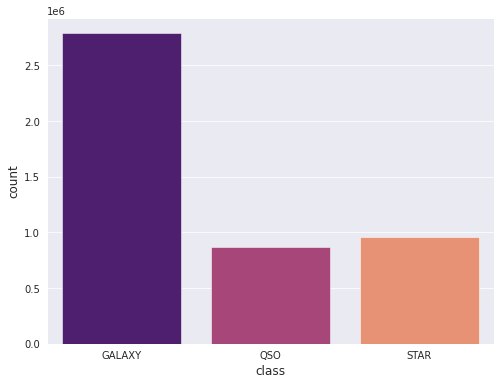

In [181]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.countplot(x=df['class'], palette = 'magma')

# Подготовка данных для классификатора

In [182]:
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({'class':labels}, inplace = True)
c = df['class'].values


In [183]:
df_g_q = df.copy()
df_g_q['ob'] = 1
df_g_q['ob'][df_g_q['subClass'] == 'OB'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [184]:
df_g_q = df_g_q[(df_g_q['class'] != 1) | (df_g_q['ob'] == 0)] #оставляе в выборке только ОВ звезды, галактики и квазары
df_g_q.shape

(3667956, 18)

In [185]:
df_g_q.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,ob
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,2,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795,1
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,3,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354,1
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,2,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257,1
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,2,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923,1
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,2,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757,1


In [186]:
X_g_q =  df_g_q.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y_g_q = df_g_q['ob'].values
c_g_q = df_g_q['class'].values

Ниже представлена функция для разделения выборки на тестовую и обучающую с нормировкой признаков

In [219]:
def data_preparation_g_q(X, y, c, test_size = 0.2):
    count = np.min(((y==1).sum(), (y==0).sum()))
    print(count, (y==0).sum(), (y==1).sum())
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[c==2], y[c==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[c==3], y[c==3], test_size=test_size, random_state = 43)
    
    count = X0_train.shape[0]
    count1 = X0_test.shape[0]
    #i1 = 5
    i2 = 4
    i3 = 2
    X_train, X_test = np.concatenate((X0_train[:count], X2_train[:count//i2], X3_train[:2*count//i3])), np.concatenate((X0_test, X2_test[:count1//2], X3_test[:count1//2]))
    y_train, y_test = np.concatenate((y0_train[:count], y2_train[:count//i2], y3_train[:2*count//i3])), np.concatenate((y0_test, y2_test[:count1//2], y3_test[:count1//2]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    X0_train_not_scaling = X0_train.copy()
    X2_train_not_scaling = X2_train[:count//i2].copy()
    X3_train_not_scaling = X3_train[:2*count//i3].copy() 

    X0_test_not_scaling = X0_test.copy()
    X2_test_not_scaling = np.concatenate((X2_test, X2_train[count//i2:])).copy()
    X3_test_not_scaling = np.concatenate((X3_test, X3_train[2*count//i3:])).copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    X2_test = robust.transform(np.concatenate((X2_test, X2_train[count//i2:])))
    y2_test = np.concatenate((y2_test, y2_train[count//i2:]))
    X2_train = robust.transform(X2_train[:count//i2])
    y2_train = y2_train[:count//i2]
    X3_test = robust.transform(np.concatenate((X3_test, X3_train[2*count//i3:])))
    y3_test = np.concatenate((y3_test, y3_train[2*count//i3:]))
    X3_train = robust.transform(X3_train[:2*count//i3])
    y3_train = y3_train[:2*count//i3]
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

# Классификатор OB против Галактик и Квазаров

In [220]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation_g_q(X_g_q, y_g_q, c_g_q, 0.2)

13731 13731 3654225


Распределение обучающей выборки по яркости

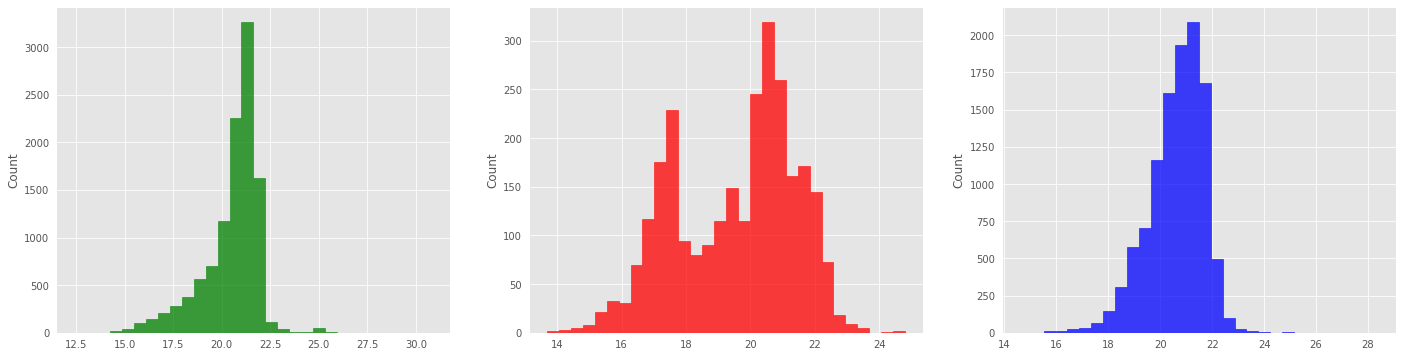

In [221]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train_not_scaling[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train_not_scaling[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

In [222]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24714, 10) (5493, 10) (24714,) (5493,)


Лучшие модели: 

In [223]:
from lightgbm import LGBMClassifier
#gb = joblib.load('gb.pkl')
gb = LGBMClassifier(n_estimators=1100,
                    num_leaves=10,
                    learning_rate=0.07,
                    max_depth=13,
                    min_child_weight=2,
                    subsample=0.83,
                    colsample_bytree=0.4)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      2747
           1       0.88      0.91      0.90      2746

    accuracy                           0.89      5493
   macro avg       0.89      0.89      0.89      5493
weighted avg       0.89      0.89      0.89      5493

Confusion Matrix: 
 [[2404  343]
 [ 242 2504]]
Training Score:  0.891964068948774
Testing Score:  0.8935008192244676


In [224]:
 import time
t = time.time()
rf = RandomForestClassifier(n_estimators=500, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2747
           1       0.88      0.91      0.89      2746

    accuracy                           0.89      5493
   macro avg       0.89      0.89      0.89      5493
weighted avg       0.89      0.89      0.89      5493

Confusion Matrix: 
 [[2396  351]
 [ 241 2505]]
Training Score:  1.0
Testing Score:  0.8922264700527944
73.82982349395752


# Разделим данные равномерно по яркости

In [226]:
def data_preparation_gq(X, y, c, test_size = 0.2):
    count = np.min(((y==1).sum(), (y==0).sum()))
    print(count, (y==0).sum(), (y==1).sum())
    
    X0_train, X0_test, y0_train, y0_test = np.zeros((1, 10)), np.zeros((1, 10)), np.zeros((1, )), np.zeros((1, ))
    X2_train, X2_test, y2_train, y2_test, X2_add, y2_add = np.zeros((1, 10)), np.zeros((1, 10)), np.zeros((1, )), np.zeros((1, )), np.zeros((1, 10)), np.zeros((1, ))
    X3_train, X3_test, y3_train, y3_test, X3_add, y3_add = np.zeros((1, 10)), np.zeros((1, 10)), np.zeros((1, )), np.zeros((1, )), np.zeros((1, 10)), np.zeros((1, ))
  
    n = 10

    X0 = X[y==0]
    y0 = y[y==0]
    X2 = X[c==2]
    y2 = y[c==2]
    X3 = X[c==3]
    y3 = y[c==3]

    X0 = X0[X0[:,7].argsort()]
    y0 = y0[X0[:,7].argsort()]

    shift = len(y0)//n

    for i in range(0, n):
            #проходим для каждого смещения по яркости
            r1 = X0[i*shift][7]
            r2 = X0[(i+1) * shift - 1][7]
            X20, X30 = X2[(X2[:, 7] >= r1) & (X2[:, 7] <= r2)], X3[(X3[:, 7] >= r1) & (X3[:, 7] <= r2)]
            y20, y30 = y2[(X2[:, 7] >= r1) & (X2[:, 7] <= r2)], y3[(X3[:, 7] >= r1) & (X3[:, 7] <= r2)]

            #сохраняем неиспользуемые примеры
            ind2 = np.random.choice(len(y20), size=shift//2, replace=False)
            ind0 = np.arange(len(y20))
            ind = np.array([x for x in ind0 if x not in ind2])
            X2_add = np.concatenate((X2_add, X20[ind]))
            y2_add = np.concatenate((y2_add, y20[ind]))

            ind3 = np.random.choice(len(y30), size=shift//2, replace=False)
            ind0 = np.arange(len(y30))
            ind = np.array([x for x in ind0 if x not in ind3])
            X3_add = np.concatenate((X3_add, X30[ind]))
            y3_add = np.concatenate((y3_add, y30[ind]))

            #разделяем на тестовую и обучающую выборку
            X_train, X_test, y_train, y_test = train_test_split(X0[i*shift : (i+1) * shift - 1], y0[i*shift : (i+1) * shift - 1], test_size=test_size, random_state = 43)
            X0_train, X0_test = np.concatenate((X0_train, X_train)), np.concatenate((X0_test, X_test))
            y0_train, y0_test = np.concatenate((y0_train, y_train)), np.concatenate((y0_test, y_test))

            X_train, X_test, y_train, y_test = train_test_split(X20[ind2], y20[ind2], test_size=test_size, random_state = 43)
            X2_train, X2_test = np.concatenate((X2_train, X_train)), np.concatenate((X2_test, X_test))
            y2_train, y2_test = np.concatenate((y2_train, y_train)), np.concatenate((y2_test, y_test)) 

            X_train, X_test, y_train, y_test = train_test_split(X30[ind3], y30[ind3], test_size=test_size, random_state = 43)
            X3_train, X3_test = np.concatenate((X3_train, X_train)), np.concatenate((X3_test, X_test))
            y3_train, y3_test = np.concatenate((y3_train, y_train)), np.concatenate((y3_test, y_test)) 

    X_train, X_test = np.concatenate((X0_train[1:], X2_train[1:], X3_train[1:])), np.concatenate((X0_test[1:], X2_test[1:], X3_test[1:]))
    y_train, y_test = np.concatenate((y0_train[1:], y2_train[1:], y3_train[1:])), np.concatenate((y0_test[1:], y2_test[1:], y3_test[1:]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    X0_train_not_scaling = X0_train.copy()
    X2_train_not_scaling = X2_train.copy()
    X3_train_not_scaling = X3_train.copy() 

    X0_test_not_scaling = X0_test.copy()
    X2_test_not_scaling = np.concatenate((X2_test, X2_add))
    X3_test_not_scaling = np.concatenate((X3_test, X3_add))

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    X2_test = robust.transform(np.concatenate((X2_test, X2_add)))
    y2_test = np.concatenate((y2_test, y2_add))
    X2_train = robust.transform(X2_train)
    X3_test = robust.transform(np.concatenate((X3_test, X3_add)))
    y3_test = np.concatenate((y3_test, y3_add))
    X3_train = robust.transform(X3_train)
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

In [227]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation_gq(X_g_q, y_g_q, c_g_q, 0.3)

13731 13731 3654225


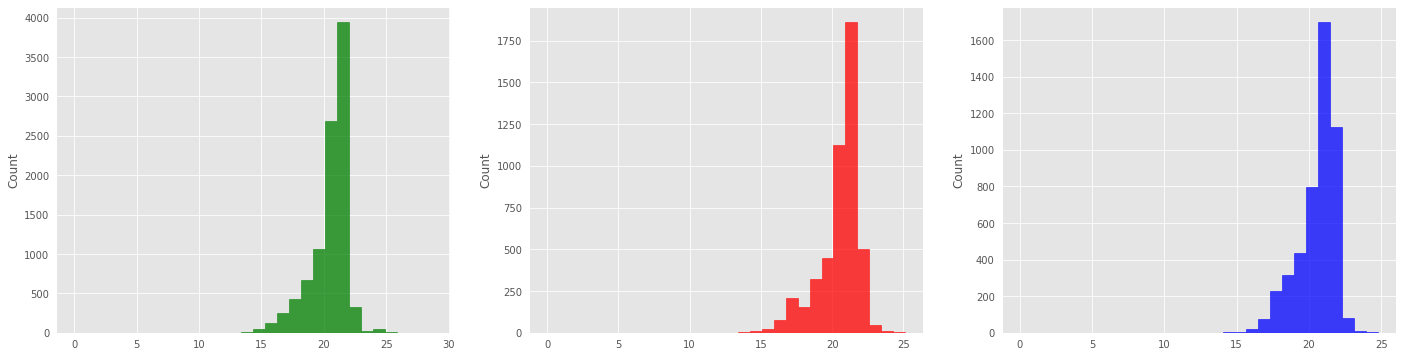

In [228]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train_not_scaling[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train_not_scaling[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

In [229]:
import time
t = time.time()
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      4120
         1.0       0.91      0.87      0.89      4120

    accuracy                           0.89      8240
   macro avg       0.89      0.89      0.89      8240
weighted avg       0.89      0.89      0.89      8240

Confusion Matrix: 
 [[3757  363]
 [ 554 3566]]
Training Score:  1.0
Testing Score:  0.8887135922330097
33.897789001464844


In [230]:
from lightgbm import LGBMClassifier

gb = LGBMClassifier(n_estimators=1100, num_leaves=60, learning_rate=0.005, max_depth=13, min_child_weight=1, subsample=0.9244, colsample_bytree=0.4)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      4120
         1.0       0.91      0.86      0.88      4120

    accuracy                           0.88      8240
   macro avg       0.89      0.88      0.88      8240
weighted avg       0.89      0.88      0.88      8240

Confusion Matrix: 
 [[3758  362]
 [ 591 3529]]
Training Score:  0.906875
Testing Score:  0.8843446601941748


# Поверка на данных с измененным поглощением: 

In [193]:
coeff = {'u': 4.239, 'g': 3.303, 'r': 2.285, 'i': 1.698, 'z': 1.263} #Rv = 3.1

In [194]:
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,2,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,3,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,2,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,2,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,2,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [195]:
def extinction(X, Ebv):

    for Mag in [0, 5]:
        for i, filters in enumerate(['u', 'g', 'r', 'i', 'z']):
            X[:, Mag+i] = X[:, Mag+i] + float(Ebv * coeff[filters])
    return X


In [196]:
from sklearn.metrics import precision_score, recall_score, f1_score

def Acc(Model, X_main, X_fit, y, index):
    
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []
    robust = RobustScaler()
    robust.fit_transform(X_fit)
    
    EBV = np.arange(0, 3.125, 0.125)
    
    for Ebv in tqdm(EBV):
        X = X_main.copy()
        X[index] = extinction(X[index], Ebv)
        
        X_test = robust.transform(X)
        
        test_ans = Model.predict(X_test)
        test_acc.append(accuracy_score(y, test_ans))
        test_f1.append(f1_score(y, test_ans, zero_division=0))
        test_precision.append(precision_score(y, test_ans, zero_division=0))
        test_recall.append(recall_score(y, test_ans, zero_division=0))

    
    return test_acc, test_f1, test_precision, test_recall, EBV

In [197]:
def visualize(test_metric_acc, train_metric_acc, test_metric_f1, train_metric_f1, test_metric_precision, train_metric_precision, test_metric_recall, train_metric_recall, grid, xlabel ='X'):
        
        def pl(metric, test_metric, train_metric):

            train, test = np.asarray(train_metric), np.asarray(test_metric)

            plt.style.use('ggplot')
            plt.figure(figsize=(16, 8))
            plt.title(metric)
            plt.plot(grid, test, label="rf")
            plt.plot(grid, train, label="gb")
            plt.xlabel(xlabel)
            plt.legend()
            plt.show()


        pl("Accuracy", test_metric_acc, train_metric_acc)
        pl("F1_score", test_metric_f1, train_metric_f1)
        pl("Precision", test_metric_precision, train_metric_precision)
        pl("Recall", test_metric_recall, train_metric_recall)

Поводим эксперементы на классификаторах с разделением тестовых данных по количеству 

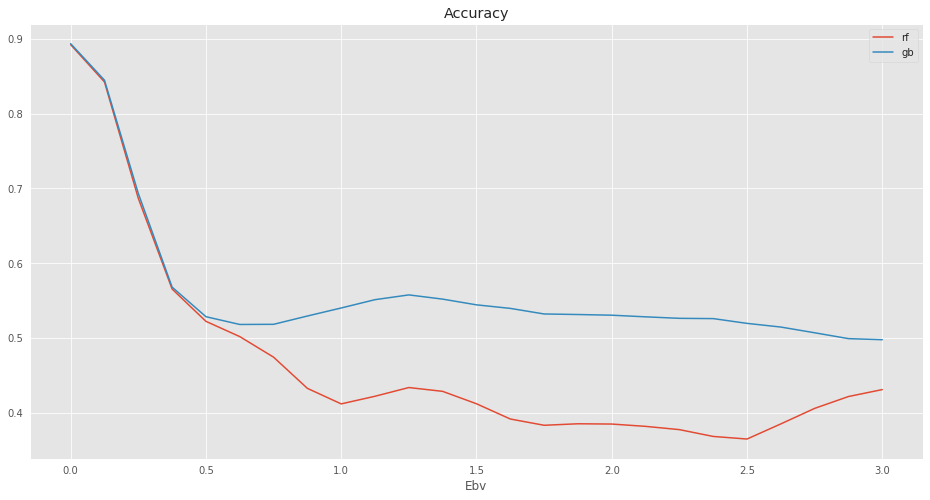

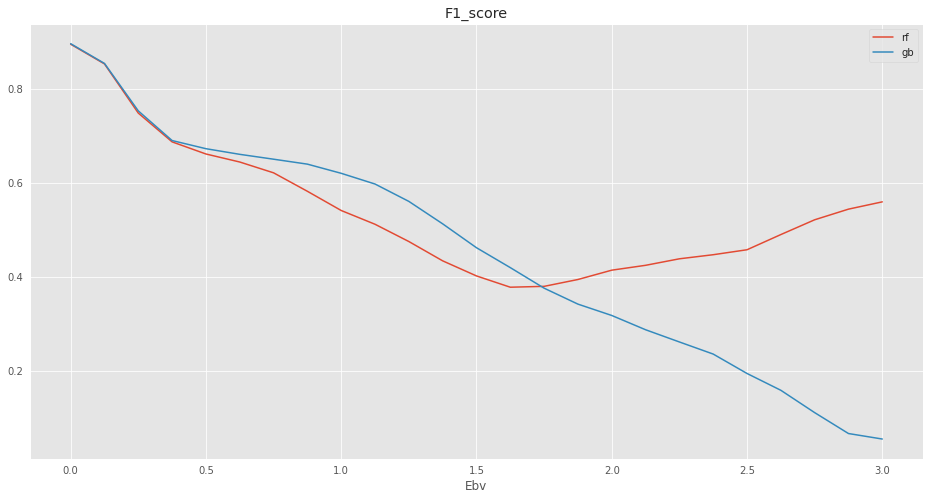

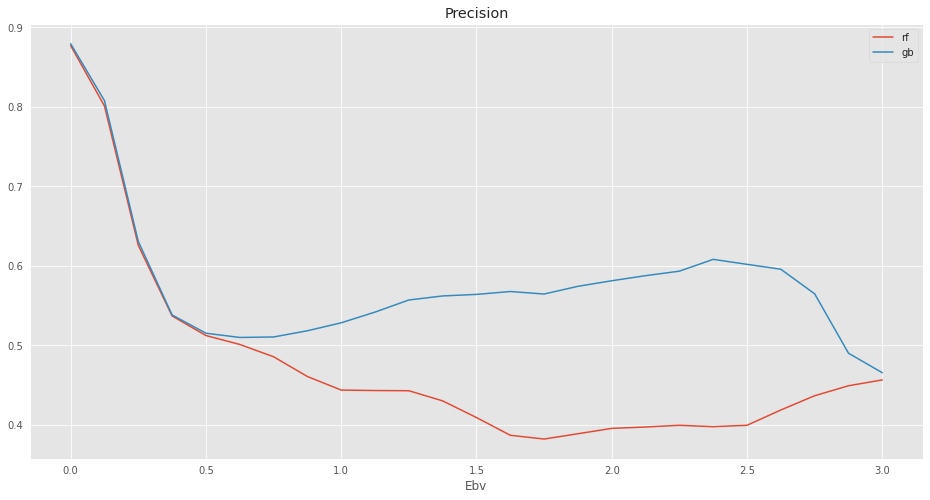

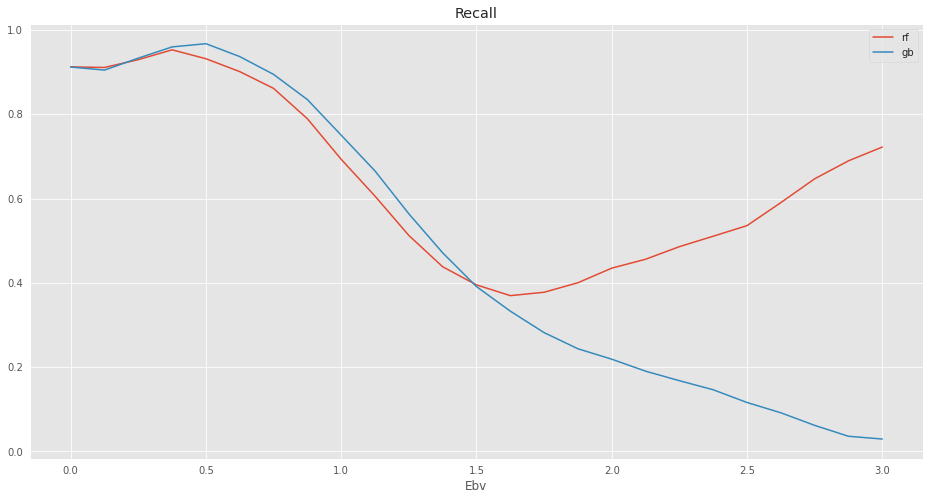

In [225]:
#Искажаем все данные 
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test, y_test==y_test)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test, y_test==y_test)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

In [ ]:
#Искажаем OB  
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test, y_test==0)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test, y_test==0)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

In [ ]:
#Искажаем не OB  
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test, y_test==1)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test, y_test==1)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

Эксперементы для классификаторов, чья выборка была разделена равномерно по яркости 

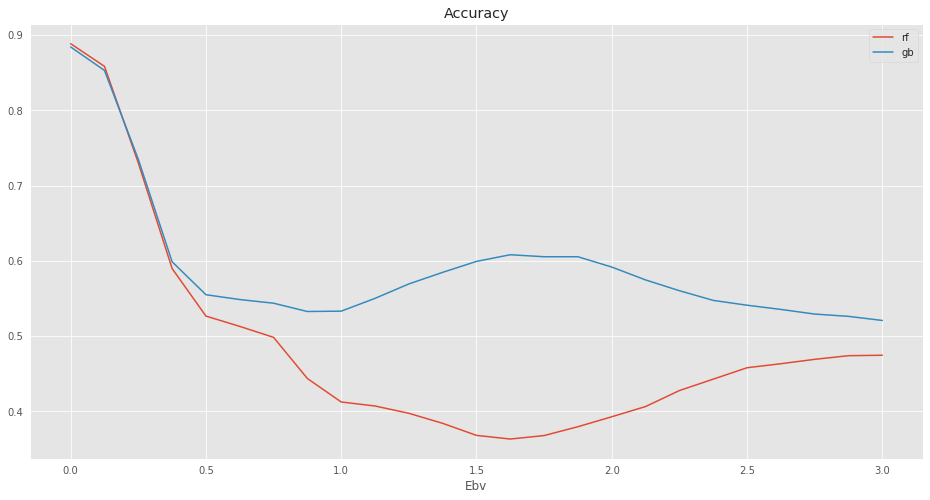

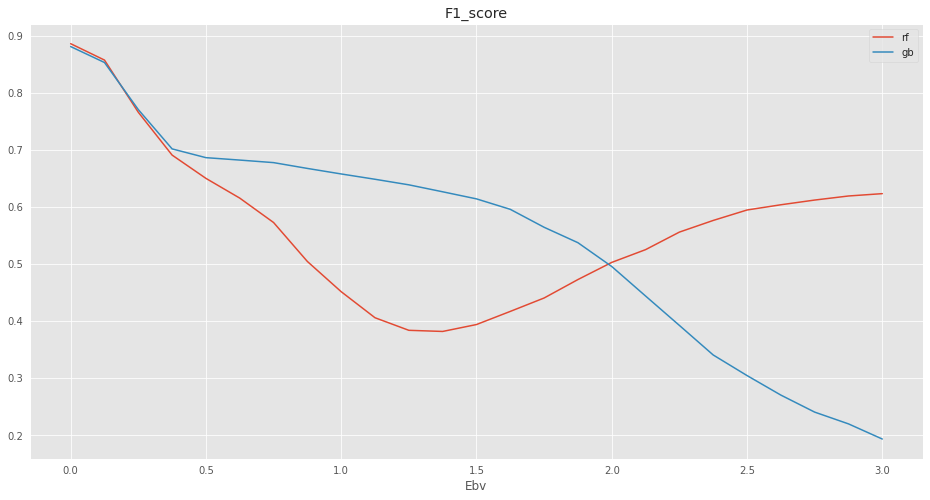

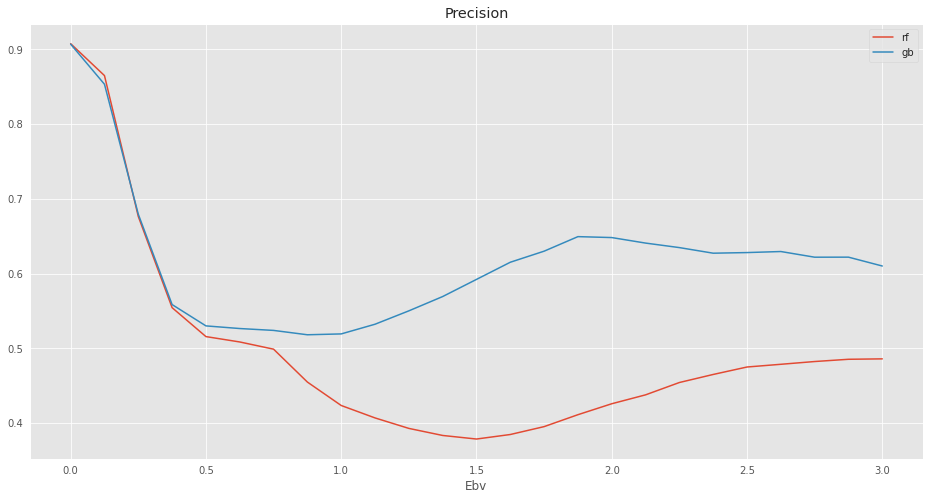

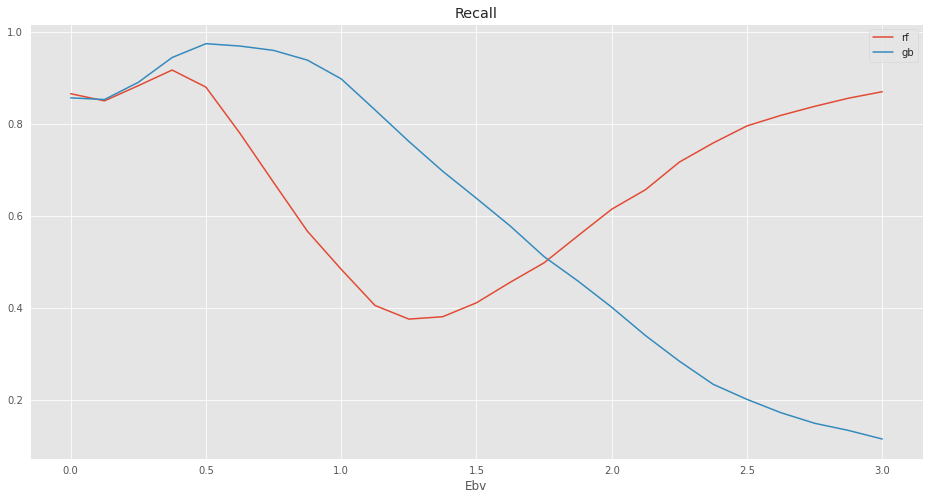

In [231]:
#Искажаем все данные 
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test, y_test==y_test)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test, y_test==y_test)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

In [ ]:
#Искажаем OB  
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test, y_test==0)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test, y_test==0)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

In [ ]:
#Искажаем не OB  
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf, X_test_not_scaling, X_train_not_scaling, y_test, y_test==1)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb, X_test_not_scaling, X_train_not_scaling, y_test, y_test==1)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

Таким образом, при искажении всех данных наиболее выйграшними становятся классификаторы, чьи начальные данные были распределены равномерно по яркости

Необходимо в тренирововчную выборку добавить элементы, искаженные поглощением


# Добавление поглощения в тренировочную выборку 

In [232]:
def X_extinction(X):

    index = np.random.choice(X.shape[0], X.shape[0]//4, replace=False)
    EBV = np.arange(0.125, 3.125, 0.125) #np.random.uniform(0.1, 3, 24)#
    j = len(index) // 24
    X_ex = X.copy()

    for i, Ebv in enumerate(tqdm(EBV)):
            index1 = index[i * j : (i + 1) * j]
            X_ex[index1] = extinction(X_ex[index1], Ebv)

    return X_ex

In [233]:
X_train_extinction = X_extinction(X_train_not_scaling)
X_test_extinction = X_extinction(X_test_not_scaling)
robust = RobustScaler()
X_fit = robust.fit_transform(X_train_extinction)
X_check = robust.transform(X_test_extinction)

In [234]:
rf_ex = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf_ex.fit(X_fit, y_train)
y_pred = rf_ex.predict(X_check)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf_ex.score(X_fit, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf_ex.score(X_check, y_test)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      4120
         1.0       0.89      0.83      0.86      4120

    accuracy                           0.87      8240
   macro avg       0.87      0.87      0.87      8240
weighted avg       0.87      0.87      0.87      8240

Confusion Matrix: 
 [[3703  417]
 [ 691 3429]]
Training Score:  1.0
Testing Score:  0.8655339805825243


In [235]:
gb_ex = LGBMClassifier(n_estimators=1100, num_leaves=60, learning_rate=0.005, max_depth=13, min_child_weight=1, subsample=0.9244, colsample_bytree=0.4)
gb_ex.fit(X_fit, y_train)
pred = gb_ex.predict(X_check)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb_ex.score(X_fit, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb_ex.score(X_check, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.82      0.89      0.86      4120
         1.0       0.88      0.81      0.84      4120

    accuracy                           0.85      8240
   macro avg       0.85      0.85      0.85      8240
weighted avg       0.85      0.85      0.85      8240

Confusion Matrix: 
 [[3679  441]
 [ 788 3332]]
Training Score:  0.8814583333333333
Testing Score:  0.8508495145631068


Попробуем проверить данные классификаторы на устойчивость при поглощении 

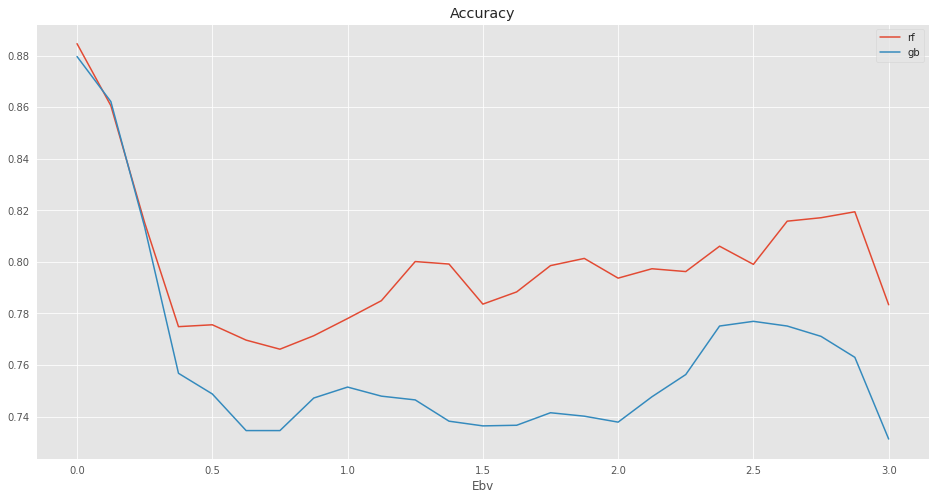

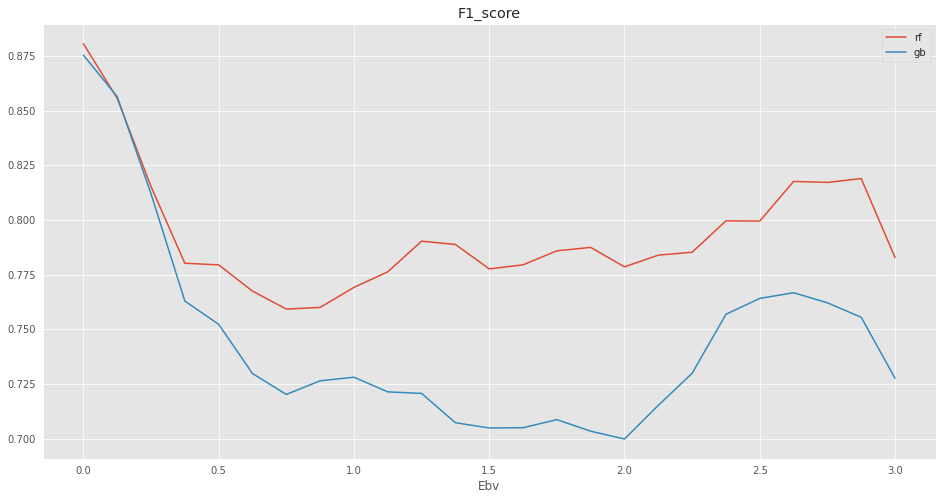

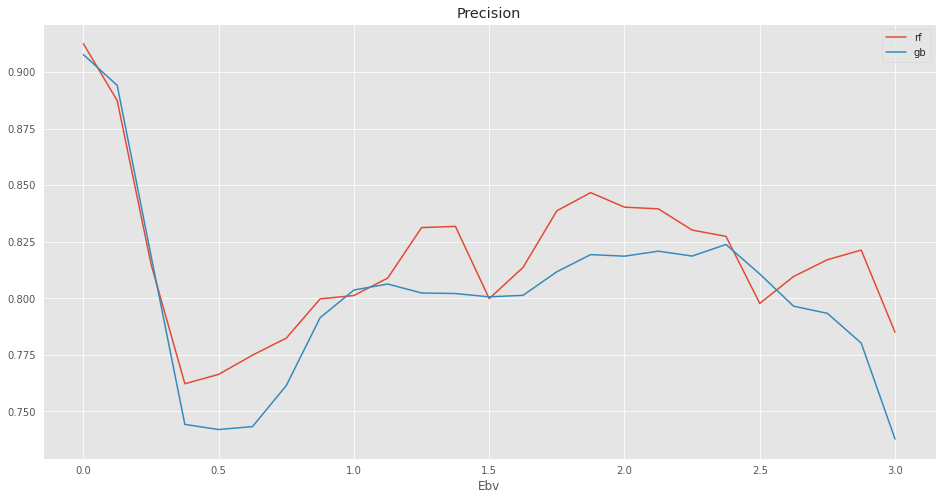

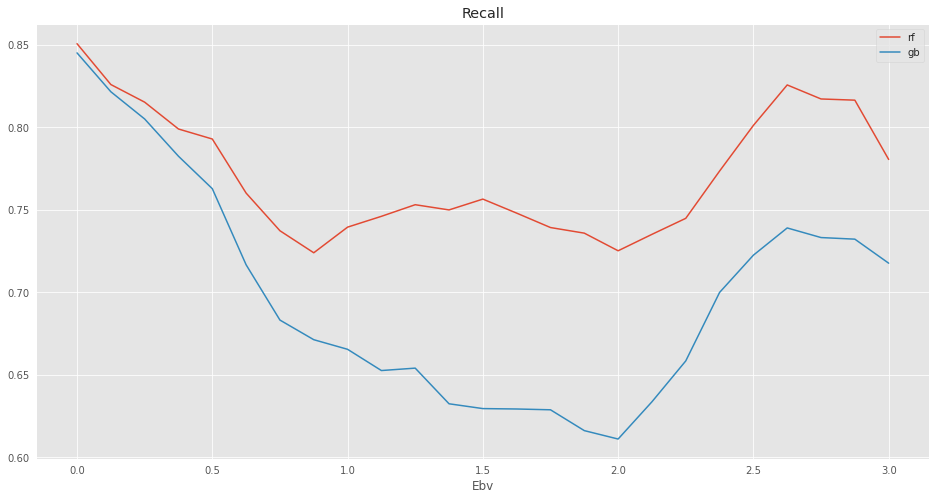

In [236]:
#Искажаем все данные 
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf_ex, X_test_not_scaling, X_train_extinction, y_test, y_test==y_test)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb_ex, X_test_not_scaling, X_train_extinction, y_test, y_test==y_test)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

Точность уже намного выше. Необходимо подобрать параметры для классификаторов.

Попробуем добавить в обучающую выборку элементы с поглощением, посмотрим, как изменится точность 

In [237]:
def X_extinction_add(X, y):
    index = np.random.choice(X.shape[0], X.shape[0]//4, replace=False)
    EBV = np.arange(0.125, 3.125, 0.125) #np.random.uniform(0.1, 3, 24)
    j = len(index) // 24
    X_ex = X.copy()
    y_ex = y.copy()

    for i, Ebv in enumerate(tqdm(EBV)):
            index1 = index[i * j : (i + 1) * j]
            X_ = X[index1]
            y_ = y[index1]

            X_ = extinction(X_, Ebv)
            X_ex = np.concatenate((X_ex, X_))
            y_ex = np.concatenate((y_ex, y_))


    return X_ex, y_ex

In [238]:
X_train_extinction, y_train_ex = X_extinction_add(X_train_not_scaling, y_train)
X_test_extinction, y_test_ex = X_extinction_add(X_test_not_scaling, y_test)
robust = RobustScaler()
X_fit = robust.fit_transform(X_train_extinction)
X_check = robust.transform(X_test_extinction)

In [239]:
rf_ex = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf_ex.fit(X_fit, y_train_ex)
y_pred = rf_ex.predict(X_check)
print('Classification Report: \n', classification_report(y_test_ex, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test_ex, y_pred))
rf_train_acc = rf_ex.score(X_fit, y_train_ex)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf_ex.score(X_check, y_test_ex)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      5128
         1.0       0.89      0.84      0.86      5152

    accuracy                           0.87     10280
   macro avg       0.87      0.87      0.87     10280
weighted avg       0.87      0.87      0.87     10280

Confusion Matrix: 
 [[4580  548]
 [ 809 4343]]
Training Score:  1.0
Testing Score:  0.8679961089494164


In [240]:
gb_ex = LGBMClassifier(n_estimators=1100, num_leaves=60, learning_rate=0.005, max_depth=13, min_child_weight=1, subsample=0.9244, colsample_bytree=0.4)
gb_ex.fit(X_fit, y_train_ex)
pred = gb_ex.predict(X_check)
print('Classification Report: \n', classification_report(y_test_ex, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test_ex, pred))
gb_train_acc = gb_ex.score(X_fit, y_train_ex)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb_ex.score(X_check, y_test_ex)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      5128
         1.0       0.88      0.82      0.85      5152

    accuracy                           0.85     10280
   macro avg       0.86      0.85      0.85     10280
weighted avg       0.86      0.85      0.85     10280

Confusion Matrix: 
 [[4557  571]
 [ 934 4218]]
Training Score:  0.880625
Testing Score:  0.8535992217898832


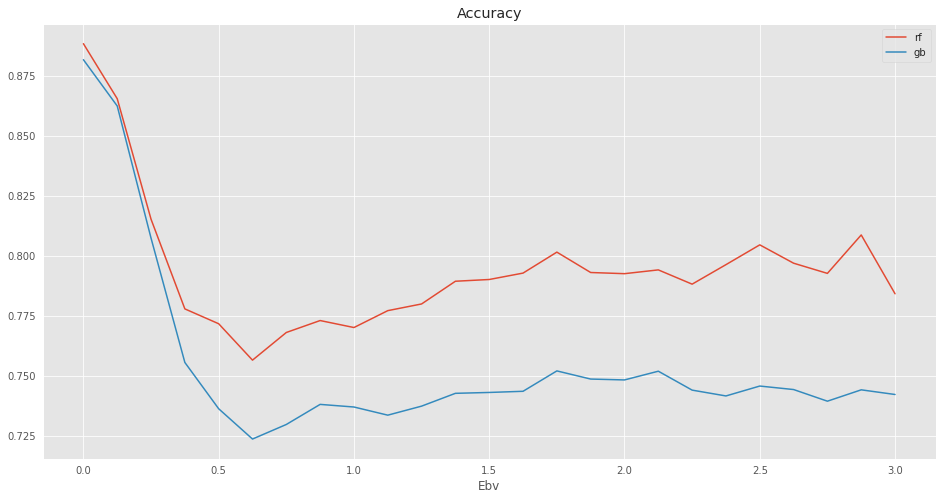

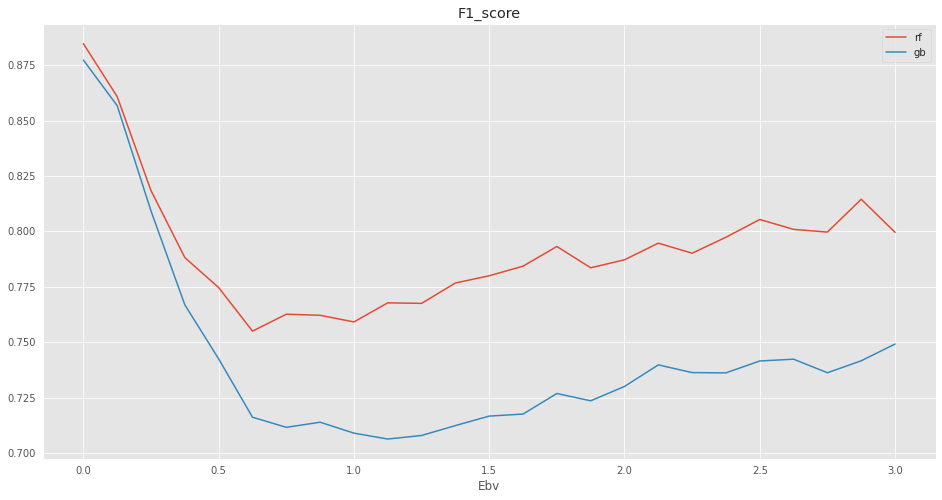

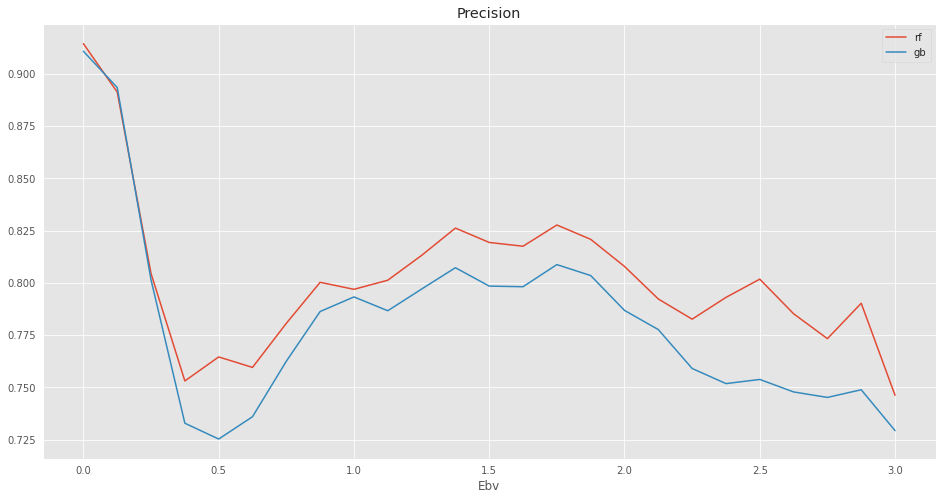

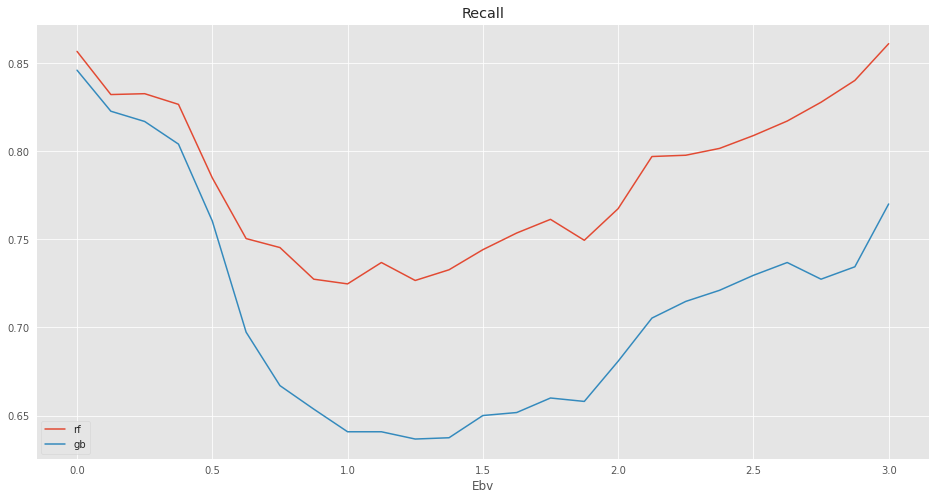

In [241]:
#Искажаем все данные 
test_acc_rf, test_f1_rf, test_precision_rf, test_recall_rf, grid = Acc(rf_ex, X_test_not_scaling, X_train_extinction, y_test, y_test==y_test)
test_acc_gb, test_f1_gb, test_precision_gb, test_recall_gb, grid = Acc(gb_ex, X_test_not_scaling, X_train_extinction, y_test, y_test==y_test)
visualize(test_acc_rf, test_acc_gb, test_f1_rf, test_f1_gb, test_precision_rf, test_precision_gb, test_recall_rf, test_recall_gb, grid, "Ebv")

Улучшения в точности не обнаружено

# Проверка точности на реальных данных с Gaia 

In [166]:
df_gaia = pd.read_csv('/content/drive/MyDrive/Научная работа /Спецсем/ParallaxAll.csv') 
df_gaia

,parallax,parallax_error,objID,ra,dec
0,NaN,NaN,1237663784217084190,45.026711,0.081701
1,-0.439763,0.338902,1237663784217084094,44.952618,0.084945
2,1.050169,0.332374,1237663784217084186,45.005005,0.102012
3,NaN,NaN,1237663784217149522,45.124130,0.136712
4,2.132702,0.223822,1237663784217149606,45.146336,0.160399
...,...,...,...,...,...
31995,0.090696,0.146929,1237660552767865450,66.789141,33.185772
31996,0.712986,0.424242,1237660552767930829,66.795253,33.285647
31997,0.349384,0.126142,1237660552767930829,66.795253,33.285647
31998,0.268322,0.335924,1237660552767930829,66.795253,33.285647


In [167]:
df_gaia = df_gaia.drop(['ra', 'dec'], axis = 1).drop_duplicates()

In [168]:
df_parallax = df_g_q.merge(df_gaia.dropna(axis='index', how='any', subset=['parallax']), how='inner')

In [169]:
np.sum(df_parallax['class']==1), np.sum(df_parallax['class']!=1)

(84, 4007)

In [170]:
df_parallax[df_parallax['subClass'] == 'OB']

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,ob,parallax,parallax_error
161,1237678662515556491,40.893338,4.556515,-0.000451,0.000058,1,OB,20.02449,18.81674,18.47929,18.32945,18.27645,20.05601,18.78441,18.45540,18.33915,18.28566,0,-0.161725,0.381863
350,1237679167697256591,27.728250,15.388738,-0.000685,0.000054,1,OB,21.34542,20.07818,19.98452,20.00446,19.83446,21.32503,20.03105,19.99069,19.95919,19.61269,0,-1.223544,1.115043
564,1237649918972067908,29.895872,13.006520,-0.000609,0.000158,1,OB,17.42785,17.36792,17.60412,17.75276,17.96632,17.40392,17.35946,17.57782,17.75879,17.94226,0,7.861568,0.131266
577,1237649920582156540,28.690816,14.403565,-0.000531,0.000371,1,OB,19.73649,20.06364,20.44195,20.79805,20.81828,19.73508,20.04647,20.43047,20.79597,20.09384,0,0.286759,0.824091
596,1237649918435590167,30.690283,12.367056,-0.000571,0.000321,1,OB,18.14322,18.47751,18.82707,19.09133,19.48849,18.10225,18.45135,18.81668,19.08989,19.41587,0,0.411728,0.325099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1237679503791423745,22.760231,19.286947,-0.000668,0.000146,1,OB,22.48240,20.84342,20.50112,20.26754,19.82322,22.05209,20.74165,20.48860,20.27240,19.84470,0,0.974365,0.984723
2378,1237670960016982199,43.250991,32.925359,0.000011,0.000003,1,OB,14.83081,14.28026,14.51440,14.69911,14.89812,14.82755,14.24851,14.51266,14.70089,14.88539,0,0.100888,0.052534
2613,1237679461364990248,25.346302,19.573026,-0.000044,0.000064,1,OB,21.39578,20.49298,20.07502,19.82368,19.84898,21.43524,20.47333,20.06059,19.81483,19.87586,0,0.869482,0.695506
3301,1237666275815653698,29.086197,23.516715,-0.000166,0.000071,1,OB,21.72160,20.55849,20.03633,19.82479,19.66253,21.73969,20.56554,20.03724,19.83228,19.47761,0,0.906698,0.737826


In [171]:
#Проверим точность распознования: 
X = df_parallax.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob', 'parallax', 'parallax_error'], axis = 1).values
y = df_parallax['ob'].values
c = df_parallax['class'].values

X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation_g_q(X, y, c, 0.1)

84 84 4007


In [172]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [174]:
pred = gb.predict(X)
print('Classification Report: \n', classification_report(y, pred))
print('Confusion Matrix: \n', confusion_matrix(y, pred))
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X, y)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.42      0.55        84
           1       0.65      0.92      0.77       101

    accuracy                           0.69       185
   macro avg       0.73      0.67      0.66       185
weighted avg       0.73      0.69      0.67       185

Confusion Matrix: 
 [[35 49]
 [ 8 93]]
Training Score:  0.8815416666666667
Testing Score:  0.6918918918918919


Слишком мало данных, чтобы можно было судить о точности